# Deep Learning Models  

This notebook contains the Deep Learning models we will use.

Here we are using two models:
1. LSTM
2. CNN1d

Importing relevant libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder

2025-02-27 10:00:04.007823: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 10:00:04.014092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 10:00:04.021374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 10:00:04.023479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 10:00:04.029287: I tensorflow/core/platform/cpu_feature_guar

Defining training parameters.

In [2]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
PATIENCE = 50

#### Data Loading and Directory Setup

Loads training and test data for multiple stocks. The data is read from CSV files located in the specified `data_dir`, and the individual stock datasets are concatenated into unified training (`train_df`) and testing (`test_df`) DataFrames.

The models will be saved in the directory specified by `save_dir`.


In [3]:
# Define directories for data and model saving
data_dir = '/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/data/FIAP_PI'
save_dir = "/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models"
save_dir_lstm=f"{save_dir}/lstm"
save_dir_cnn=f"{save_dir}/cnn"

stocks = ['BBAS3.SA', 'CSNA3.SA', 'PETR4.SA', 'VALE3.SA'] 

# Initialize lists to store training and test DataFrames
train_dfs, test_dfs = [], []

# Load training and testing data for each stock
for stock in stocks:
    stock_dir = os.path.join(data_dir, stock)
    train_stock_df = pd.read_csv(f"{stock_dir}/treino.csv", index_col=0)
    test_stock_df = pd.read_csv(f"{stock_dir}/teste.csv", index_col=0)

    # Label adjustment
    train_stock_df.iloc[:, 3] = train_stock_df.iloc[:, 3].replace(-1, 0)
    test_stock_df.iloc[:, 3] = test_stock_df.iloc[:, 3].replace(-1, 0)

    # Append DataFrames to respective lists
    train_dfs.append(train_stock_df)
    test_dfs.append(test_stock_df)


In [4]:
train_dfs[0].head()

,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
1,2000-01-24,1.062769,1.071645,0,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457,1.074564
2,2000-01-26,1.087668,1.073247,0,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457
3,2000-01-27,1.064080,1.072330,0,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940
4,2000-01-28,1.036561,1.068753,0,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355
5,2000-01-31,1.035250,1.065403,0,1.036561,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767


Feature reshaping and engineerign for model input.

In [5]:
train_features, train_labels, test_features, test_labels = [], [], [], []
for train_df, test_df in zip(train_dfs, test_dfs):
    train_feature = train_df.iloc[:, 4:].values  # Shape: (n_samples, total_features)
    label = train_df.iloc[:, 3].values          # Shape: (n_samples,)
    
    # scaler = StandardScaler()
    # scaler.fit(train_feature)
    # train_feature = scaler.transform(train_feature)

    test_feature = test_df.iloc[:, 4:].values
    # test_feature = scaler.transform(test_feature)
    test_label = test_df.iloc[:, 3].values

    # Compute difference.
    train_feature = (train_feature[:, :-1] - train_feature[:, 1:])
    test_feature = (test_feature[:, :-1] - test_feature[:, 1:])

    train_features.append(train_feature)
    train_labels.append(label)
    test_features.append(test_feature)
    test_labels.append(test_label)

In [6]:
for feature in train_features:
    print(feature.shape)

(4735, 14)
(4743, 14)
(4808, 14)
(4808, 14)


Define history ploting method.

In [7]:
def plot_training_history(title, history):
    """
    Plots training & validation accuracy and loss from a Keras model history.

    Parameters:
    history : keras.callbacks.History
        The history object returned by model_cnn.fit()
    """
    history_dict = history.history

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{title}")
    

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Training Loss', color='blue')
    plt.plot(history_dict['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

Defines EarlyStopping and ModelCheckpoint callbacks and a method to save a model. 

In [8]:
def define_early_stopping():
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',   # Monitor validation loss
        patience=PATIENCE,          # Stop training if val_loss doesn't improve for PATIENCE
        restore_best_weights=True,  # Restore the best model weights after stopping
        verbose=1
    )
    
    return early_stopping

# Define ModelCheckpoint callback
def save_best_model(model_name, save_dir):

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define full save path
    save_path = os.path.join(save_dir, f"best_{model_name}.keras")

    checkpoint = ModelCheckpoint(
        filepath=save_path,  # Saves model as "best_cnn.h5" or "best_lstm.h5"
        monitor="val_loss",   # Track validation loss
        save_best_only=True,  # Save only the best model
        verbose=1             # Print when a model is saved
    )
    return checkpoint

def save_last_model(model, model_name, save_dir):

    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Define full save path
    save_path = os.path.join(save_dir, f"last_{model_name}_{model.name}.keras")

    # Save the model
    model.save(save_path)

    print(f"Last model saved to: {save_path}")

Defines backtesting and evaluation metrics.

In [9]:
def backtest_strategy_np(prices, predictions, initial_cash=10000, price_index=0):
    cash = initial_cash
    position = 0
    portfolio_values = []
    
    for i in range(len(prices)):
        price = prices[i]
        signal = int(predictions[i][0])
        
        if signal == 1 and position == 0:
            shares_to_buy = int(cash // price)
            if shares_to_buy > 0:
                position = shares_to_buy
                cash -= position * price

        elif signal == 0 and position > 0:
            cash += position * price
            position = 0
        
        portfolio_value = cash + position * price
        portfolio_values.append(portfolio_value)
    
    # Final liquidation if still holding a position
    if position > 0:
        if prices.ndim > 1:
            final_price = float(prices[-1, price_index])
        else:
            final_price = float(prices[-1])
        cash += position * final_price
        position = 0
    
    final_value = cash
    return portfolio_values, final_value


In [10]:
def results(models):
    for stock, model, stock_test_df, stock_test_label, test_df in zip(stocks, models, test_features, test_labels, test_dfs):
        X_test = stock_test_df
        y_test = stock_test_label

        print(f"Test results for stock: {stock}")
        print(model.name)

        y_pred_probs = model.predict(X_test, verbose=0)
        y_pred = (y_pred_probs > 0.5).astype(int)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Print the metrics
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print("Confusion Matrix:")
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        print()

        prices = test_df.iloc[:,2].to_numpy()

        # Run the backtest simulation
        portfolio_values, final_value = backtest_strategy_np(prices, y_pred, initial_cash=10000, price_index=0)
        print(f"Final portfolio value for {stock}: R${final_value:.2f}")

        # Create a dual Y-axis plot
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

        # Plot stock prices on the left y-axis
        ax1.plot(prices, label='Stock Price', color='blue', linewidth=2)
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Stock Price', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot portfolio values on the right y-axis
        ax2.plot(portfolio_values, label='Portfolio Value', color='orange', linestyle='--', linewidth=2)
        ax2.set_ylabel('Portfolio Value', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        # Title and legend
        plt.title(f'Stock Price and Portfolio Value Over Time for {stock}')
        fig.tight_layout()
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
        plt.show()
        print()


## Models

### LSTM  Model.

In [11]:
def lstm_model():
    # Define the model
    model_lstm = Sequential([
        Input(shape=(14, 1)),               # Explicit Input layer
        LSTM(32),                           # LSTM layer with 64 units
        Dense(32, activation='relu'),       # Fully connected dense layer
        Dense(1, activation='sigmoid')      # Output layer for binary classification
    ])

    # Compile the model with binary crossentropy loss and Adam optimizer
    model_lstm.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                    metrics=['accuracy'])
    
    return model_lstm

Train results for stock: BBAS3.SA


I0000 00:00:1740661204.889883 2599643 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740661204.912565 2599643 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740661204.915300 2599643 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740661204.918700 2599643 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-02-27 10:00:06.180617: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


116/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6611 - loss: 0.6889
Epoch 1: val_loss improved from inf to 0.65947, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_BBAS3.SA_sequential.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6611 - loss: 0.6888 - val_accuracy: 0.7962 - val_loss: 0.6595
Epoch 2/200
109/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6704 - loss: 0.6749
Epoch 2: val_loss improved from 0.65947 to 0.55909, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_BBAS3.SA_sequential.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6733 - loss: 0.6740 - val_accuracy: 0.8860 - val_loss: 0.5591
Epoch 3/200
111/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7706 - loss: 0.5978
Epoch 3: val_loss improved from 0.55909 to 0.34541, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_BBAS3.SA_sequential.keras

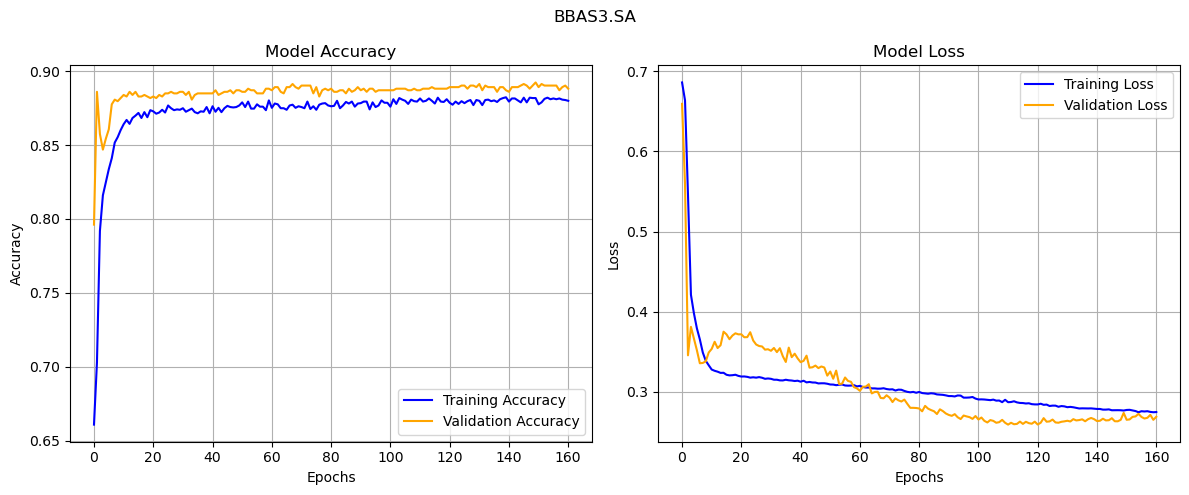

Train results for stock: CSNA3.SA


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
 94/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5956 - loss: 0.6913 
Epoch 1: val_loss improved from inf to 0.67767, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_CSNA3.SA_sequential_1.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6019 - loss: 0.6908 - val_accuracy: 0.6860 - val_loss: 0.6777
Epoch 2/200
 88/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5998 - loss: 0.6783
Epoch 2: val_loss improved from 0.67767 to 0.62394, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_CSNA3.SA_sequential_1.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5980 - loss: 0.6768 - val_accuracy: 0.7176 - val_loss: 0.6239
Epoch 3/200
 84/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6411 - loss: 0.6241
Epoch 3: val_loss improved from 0.62394 to 0.44919, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_CSNA3.SA

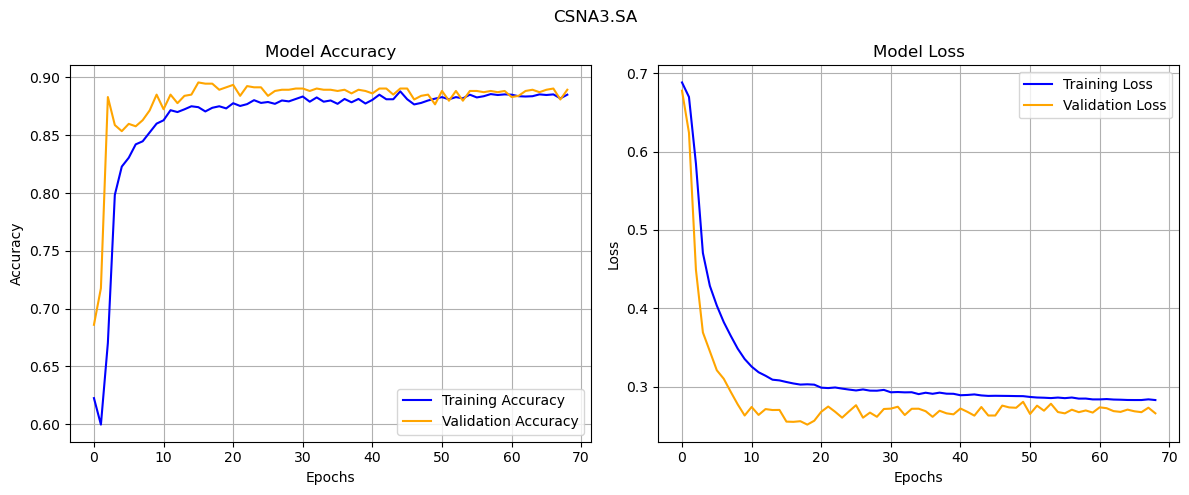

Train results for stock: PETR4.SA


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
105/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5712 - loss: 0.6906
Epoch 1: val_loss improved from inf to 0.68198, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_PETR4.SA_sequential_2.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5705 - loss: 0.6903 - val_accuracy: 0.5603 - val_loss: 0.6820
Epoch 2/200
105/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5783 - loss: 0.6779
Epoch 2: val_loss improved from 0.68198 to 0.64405, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_PETR4.SA_sequential_2.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5774 - loss: 0.6771 - val_accuracy: 0.5707 - val_loss: 0.6441
Epoch 3/200
117/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6041 - loss: 0.6223
Epoch 3: val_loss improved from 0.64405 to 0.49663, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_PETR4.SA_

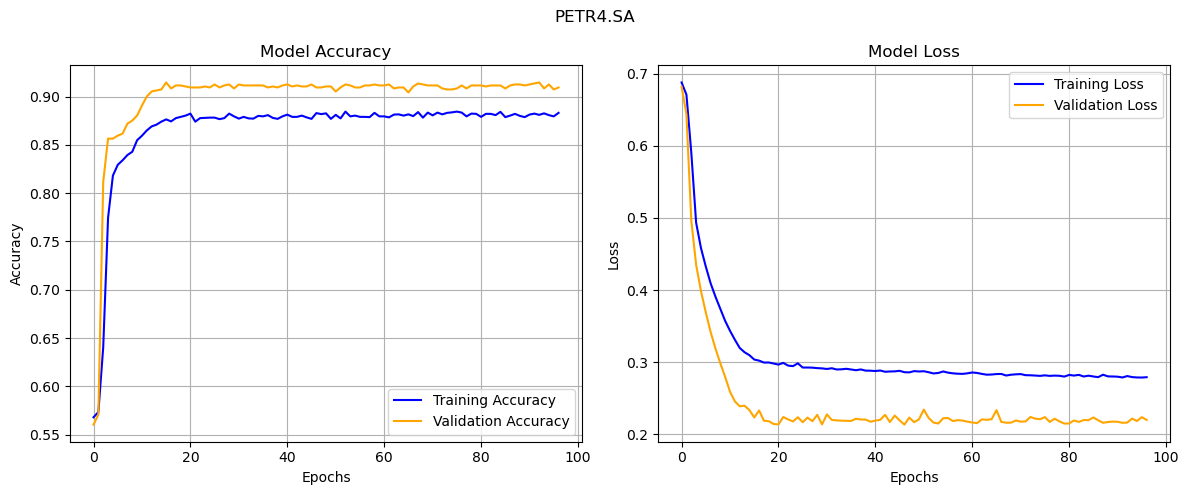

Train results for stock: VALE3.SA


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
113/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5480 - loss: 0.6923
Epoch 1: val_loss improved from inf to 0.67732, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_VALE3.SA_sequential_3.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5521 - loss: 0.6920 - val_accuracy: 0.7412 - val_loss: 0.6773
Epoch 2/200
113/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6440 - loss: 0.6773
Epoch 2: val_loss improved from 0.67732 to 0.61055, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_VALE3.SA_sequential_3.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6443 - loss: 0.6767 - val_accuracy: 0.8025 - val_loss: 0.6105
Epoch 3/200
105/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6742 - loss: 0.6138
Epoch 3: val_loss improved from 0.61055 to 0.39608, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/lstm/best_lstm_VALE3.SA_

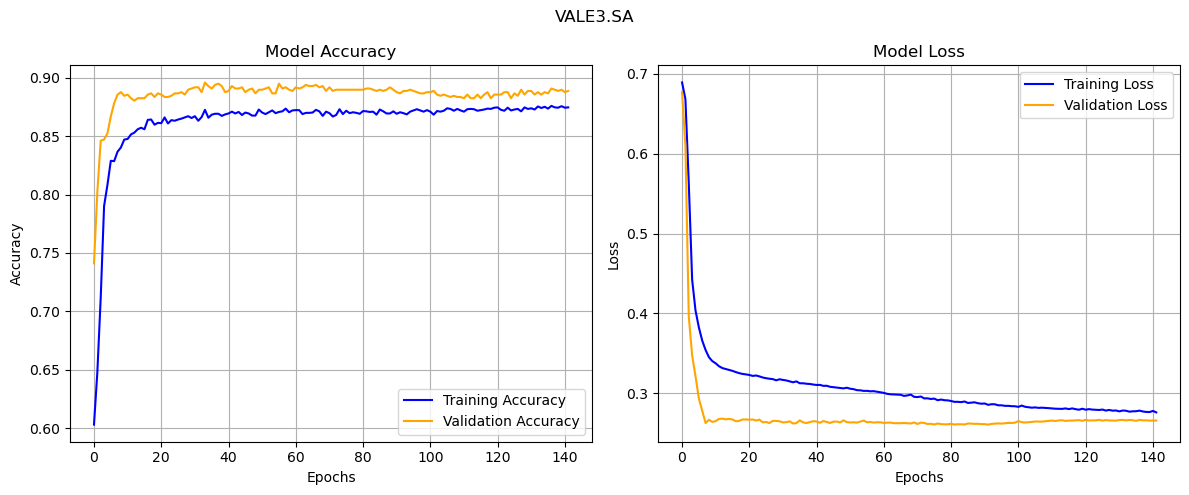

In [12]:
lstm_stock_models, lstm_stock_histories = [], []
for stock, stock_feature, stock_label in zip(stocks, train_features, train_labels):
    print(f"Train results for stock: {stock}")
    stock_model = lstm_model()

    stock_model.summary()

    lstm_checkpoint = save_best_model(f"lstm_{stock}_{stock_model.name}", save_dir_lstm)
    lstm_early_stopping = define_early_stopping()

    # Fit model
    history_lstm = stock_model.fit(
        stock_feature, stock_label,
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_split=0.2, 
        callbacks=[lstm_early_stopping, lstm_checkpoint] 
    )

    lstm_stock_models.append(stock_model)
    lstm_stock_histories.append(history_lstm)

    save_last_model(stock_model, f"lstm_{stock}", save_dir_lstm)

    plot_training_history(stock, history_lstm)


Evaluates LSTM Model for each stock.

Test results for stock: BBAS3.SA
sequential


Accuracy: 0.88
Precision: 0.85
Recall: 0.86
F1 Score: 0.85
Confusion Matrix:


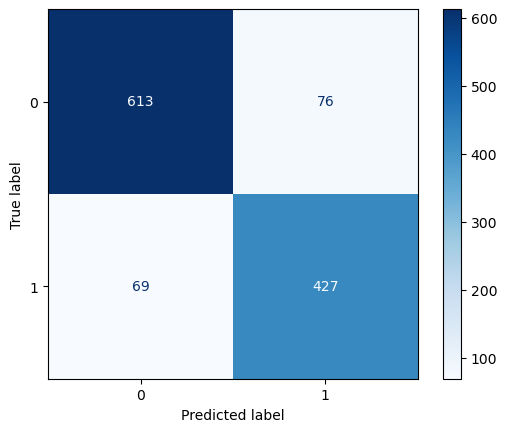


Final portfolio value for BBAS3.SA: R$62626.40


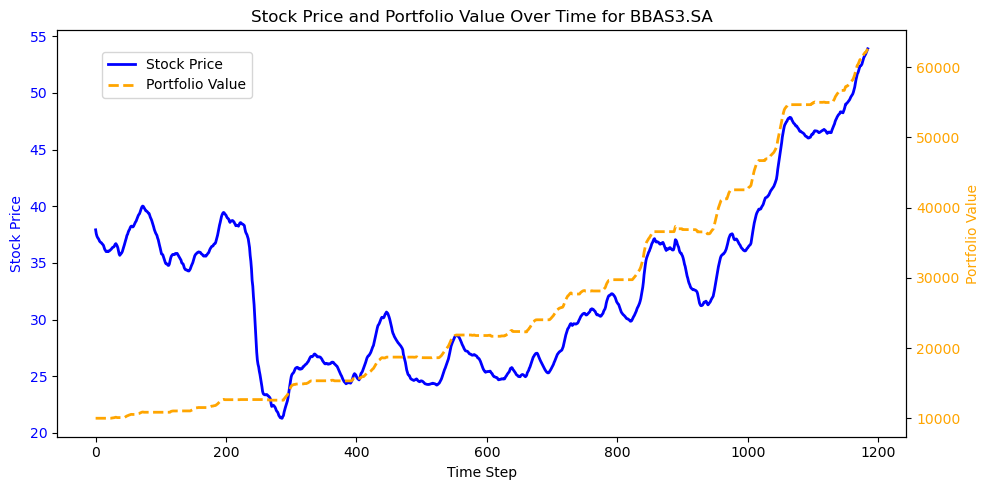


Test results for stock: CSNA3.SA
sequential_1
Accuracy: 0.88
Precision: 0.82
Recall: 0.90
F1 Score: 0.86
Confusion Matrix:


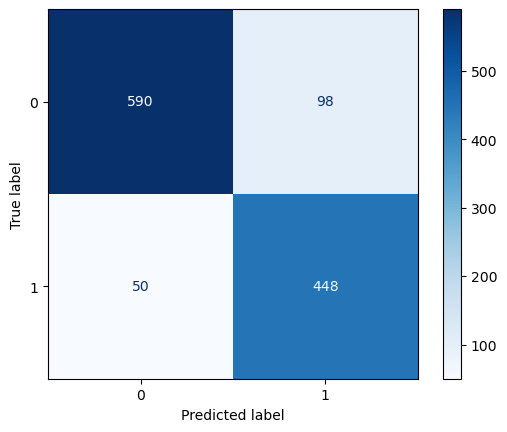


Final portfolio value for CSNA3.SA: R$278840.65


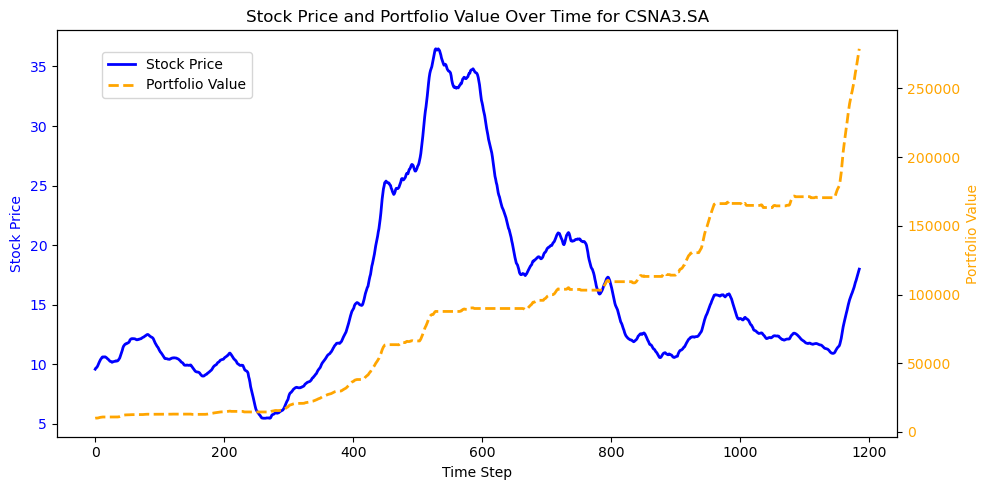


Test results for stock: PETR4.SA
sequential_2
Accuracy: 0.86
Precision: 0.84
Recall: 0.89
F1 Score: 0.87
Confusion Matrix:


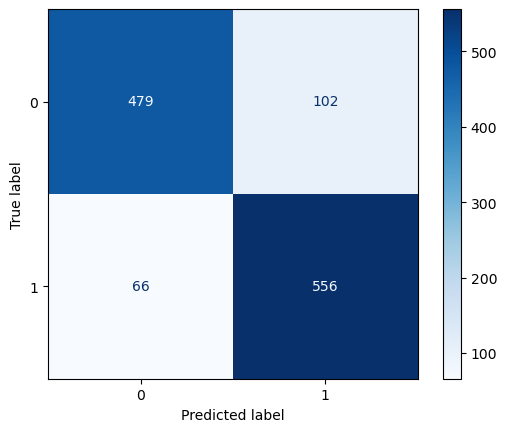


Final portfolio value for PETR4.SA: R$153745.39


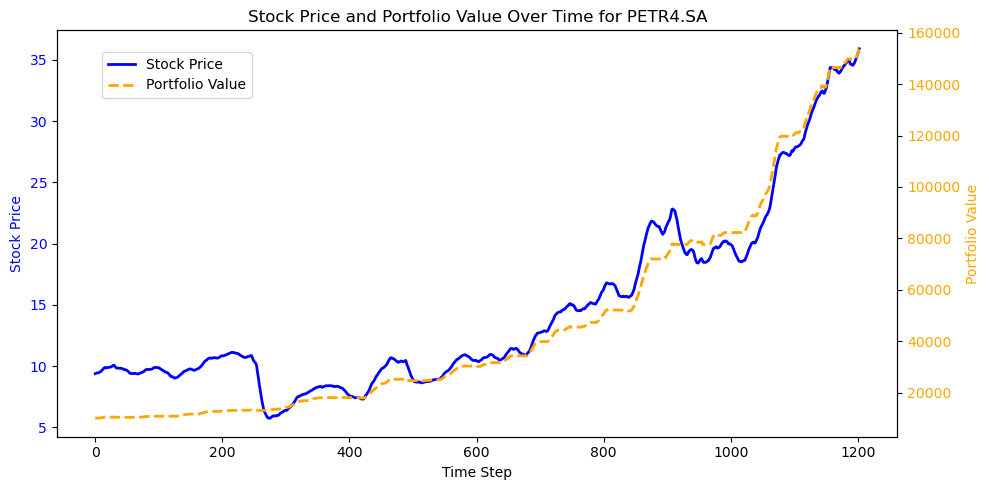


Test results for stock: VALE3.SA
sequential_3
Accuracy: 0.81
Precision: 0.89
Recall: 0.72
F1 Score: 0.79
Confusion Matrix:


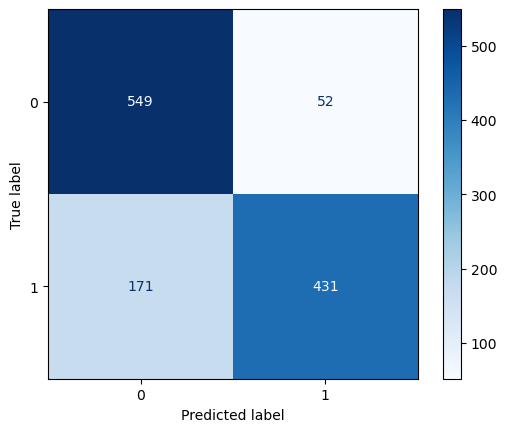


Final portfolio value for VALE3.SA: R$61597.02


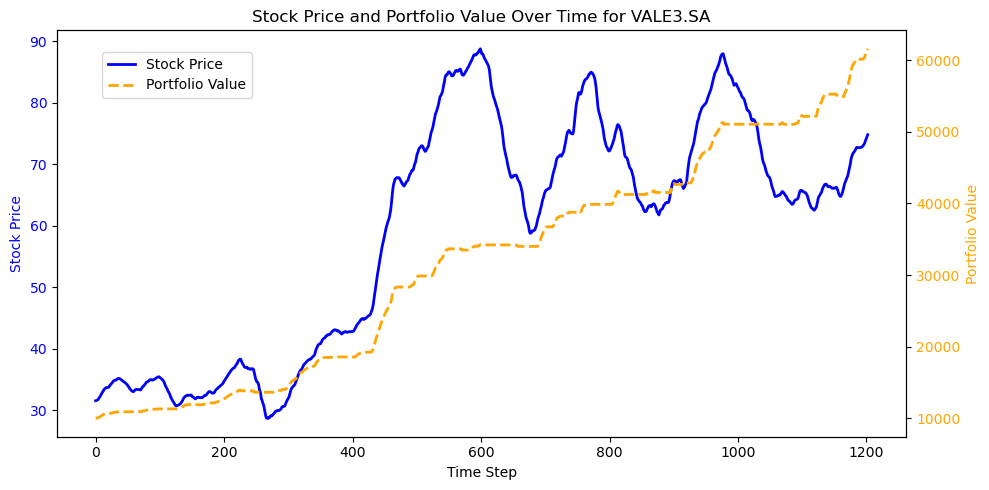

In [13]:
results(lstm_stock_models)

### CNN1d  Model.

In [14]:
def cnn_model():
    # Define the model
    model_cnn = Sequential([
        Input(shape=(14, 1)),                                   # Explicit Input layer
        Conv1D(filters=32, kernel_size=5, activation='relu'),   # 1D Convolutional layer
        MaxPooling1D(pool_size=2),                              # MaxPooling layer to reduce dimensionality
        Conv1D(filters=16, kernel_size=5, activation='relu'),   # Another Conv1D layer
        Flatten(),                                              # Flatten layer to transition from CNN to Dense
        Dense(16, activation='relu'),                           # Fully connected dense layer
        Dropout(0.3),                                           # Dropout to prevent overfitting
        Dense(1, activation='sigmoid')                          # Output layer for binary classification
    ])

    # Compile the model with binary crossentropy loss and Adam optimizer
    model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model_cnn

Train results for stock: BBAS3.SA


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 10, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 16)          │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057 (11.94 KB)

 Trainable params: 3,057 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


I0000 00:00:1740661305.536162 2599766 service.cc:146] XLA service 0x7ad728026050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740661305.536180 2599766 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-27 10:01:45.548333: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/119 ━━━━━━━━━━━━━━━━━━━━ 2:03 1s/step - accuracy: 0.4688 - loss: 0.7081

I0000 00:00:1740661306.227935 2599766 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6058 - loss: 0.6695 
Epoch 1: val_loss improved from inf to 0.31958, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_BBAS3.SA_sequential_4.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6066 - loss: 0.6691 - val_accuracy: 0.8712 - val_loss: 0.3196
Epoch 2/200
  1/119 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7188 - loss: 0.5427
Epoch 2: val_loss did not improve from 0.31958
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.8238 - loss: 0.4249 - val_accuracy: 0.8817 - val_loss: 0.3221
Epoch 3/200
  1/119 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.2278
Epoch 3: val_loss improved from 0.31958 to 0.31409, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_BBAS3.SA_sequential_4.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.8600 - loss: 0.3415 - val_accuracy: 0.9018 - val_loss: 0.3141
Ep

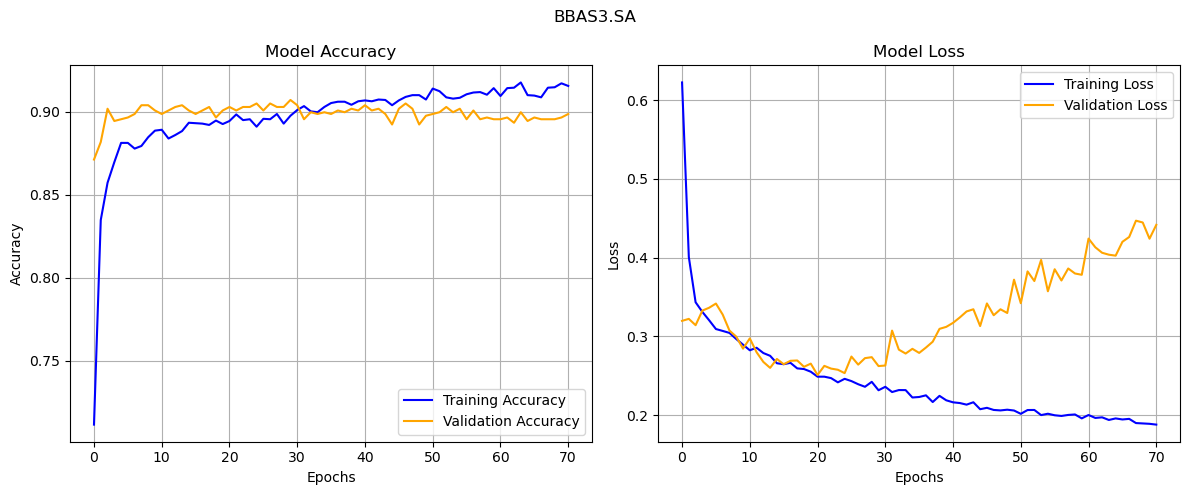

Train results for stock: CSNA3.SA


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1, 16)          │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057 (11.94 KB)

 Trainable params: 3,057 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6916 - loss: 0.6591    
Epoch 1: val_loss improved from inf to 0.39411, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_CSNA3.SA_sequential_5.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6919 - loss: 0.6587 - val_accuracy: 0.8704 - val_loss: 0.3941
Epoch 2/200
  1/119 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7500 - loss: 0.4872
Epoch 2: val_loss improved from 0.39411 to 0.26747, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_CSNA3.SA_sequential_5.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.8083 - loss: 0.4398 - val_accuracy: 0.8915 - val_loss: 0.2675
Epoch 3/200
  1/119 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8438 - loss: 0.3743
Epoch 3: val_loss improved from 0.26747 to 0.25263, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_CSNA3.S

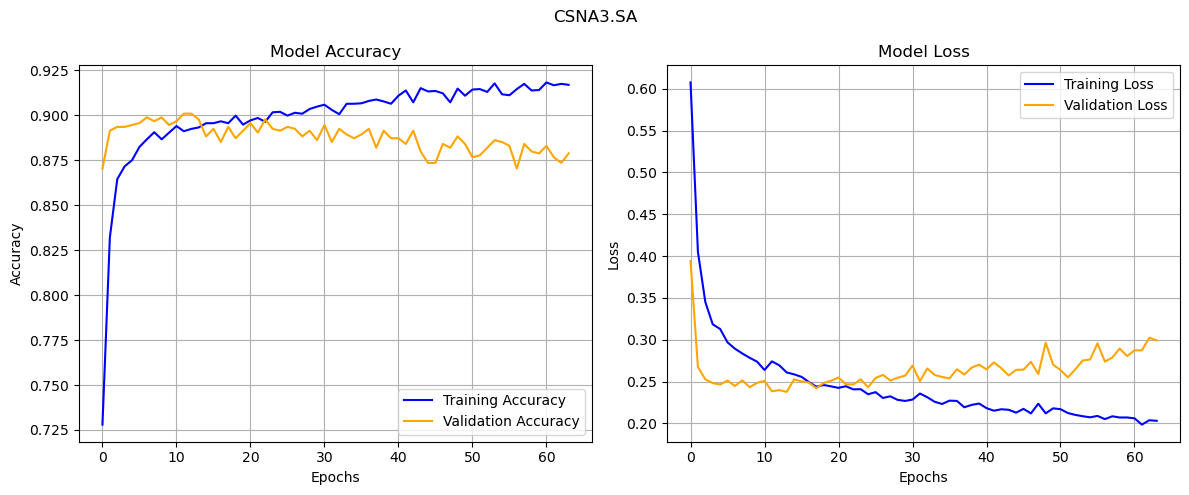

Train results for stock: PETR4.SA


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 10, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1, 16)          │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057 (11.94 KB)

 Trainable params: 3,057 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6447 - loss: 0.6549    
Epoch 1: val_loss improved from inf to 0.38273, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_PETR4.SA_sequential_6.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6453 - loss: 0.6545 - val_accuracy: 0.8857 - val_loss: 0.3827
Epoch 2/200
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8125 - loss: 0.3875
Epoch 2: val_loss improved from 0.38273 to 0.24020, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_PETR4.SA_sequential_6.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.8257 - loss: 0.4182 - val_accuracy: 0.9075 - val_loss: 0.2402
Epoch 3/200
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8750 - loss: 0.3398
Epoch 3: val_loss improved from 0.24020 to 0.20918, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_PETR4.S

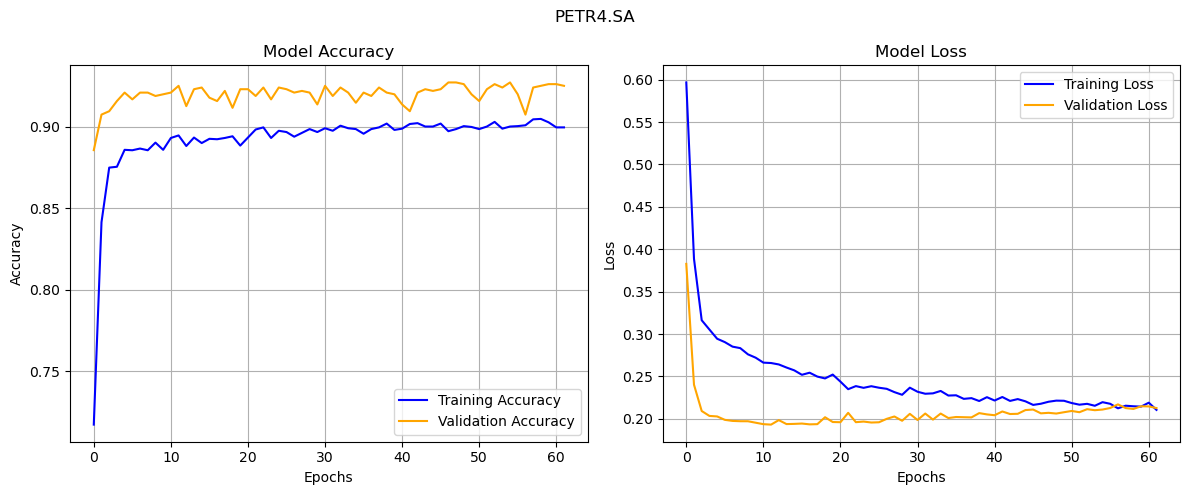

Train results for stock: VALE3.SA


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 10, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1, 16)          │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057 (11.94 KB)

 Trainable params: 3,057 (11.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5980 - loss: 0.6635    
Epoch 1: val_loss improved from inf to 0.37290, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_VALE3.SA_sequential_7.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5988 - loss: 0.6631 - val_accuracy: 0.8534 - val_loss: 0.3729
Epoch 2/200
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7812 - loss: 0.5353
Epoch 2: val_loss improved from 0.37290 to 0.28789, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_VALE3.SA_sequential_7.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.8045 - loss: 0.4472 - val_accuracy: 0.8753 - val_loss: 0.2879
Epoch 3/200
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7812 - loss: 0.3847
Epoch 3: val_loss improved from 0.28789 to 0.28600, saving model to /home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/models/cnn/best_cnn_VALE3.S

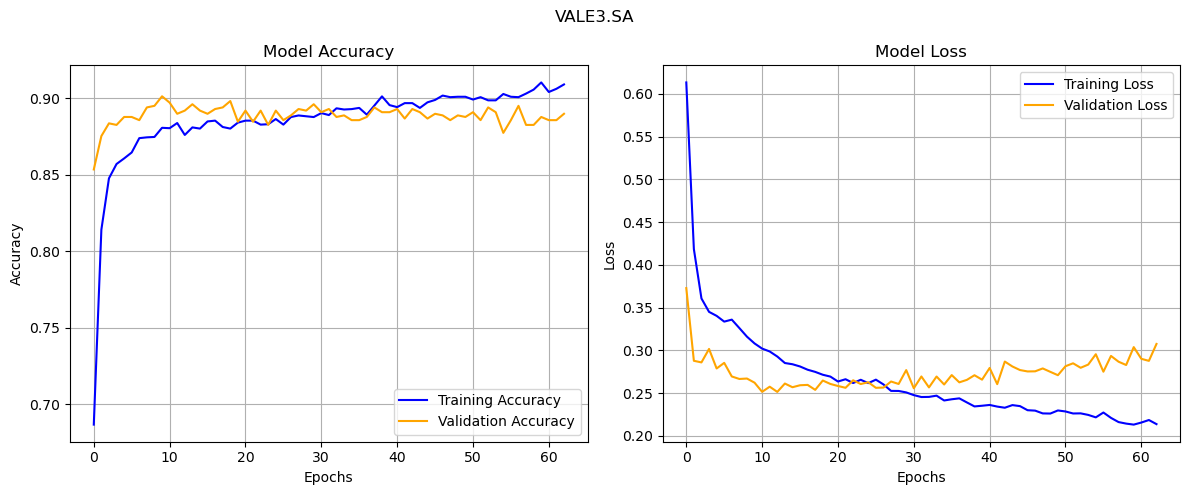

In [15]:
cnn_stock_models, cnn_stock_histories = [], []

for stock, stock_feature, stock_label in zip(stocks, train_features, train_labels):
    print(f"Train results for stock: {stock}")
    stock_model = cnn_model()

    stock_model.summary()

    cnn_checkpoint = save_best_model(f"cnn_{stock}_{stock_model.name}", save_dir_cnn)
    cnn_early_stopping = define_early_stopping()

    # Fit the model
    history_cnn = stock_model.fit(
        stock_feature, stock_label,
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_split=0.2, 
        callbacks=[cnn_early_stopping, cnn_checkpoint]  
    )
    
    cnn_stock_models.append(stock_model)
    cnn_stock_histories.append(history_cnn)

    save_last_model(stock_model, f"cnn_{stock}", save_dir_cnn)

    plot_training_history(stock, history_cnn)

Evaluates CNN1d Model for each stock.

Test results for stock: BBAS3.SA
sequential_4
Accuracy: 0.88
Precision: 0.85
Recall: 0.88
F1 Score: 0.86
Confusion Matrix:


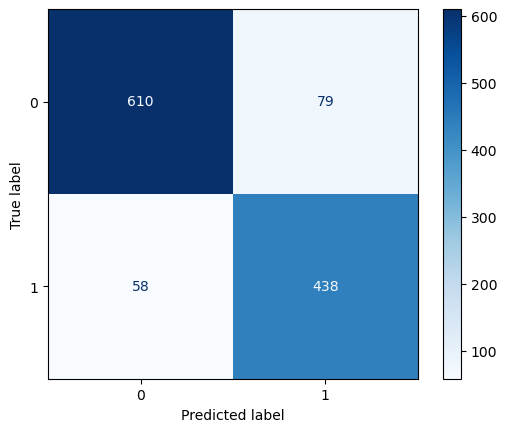


Final portfolio value for BBAS3.SA: R$62045.90


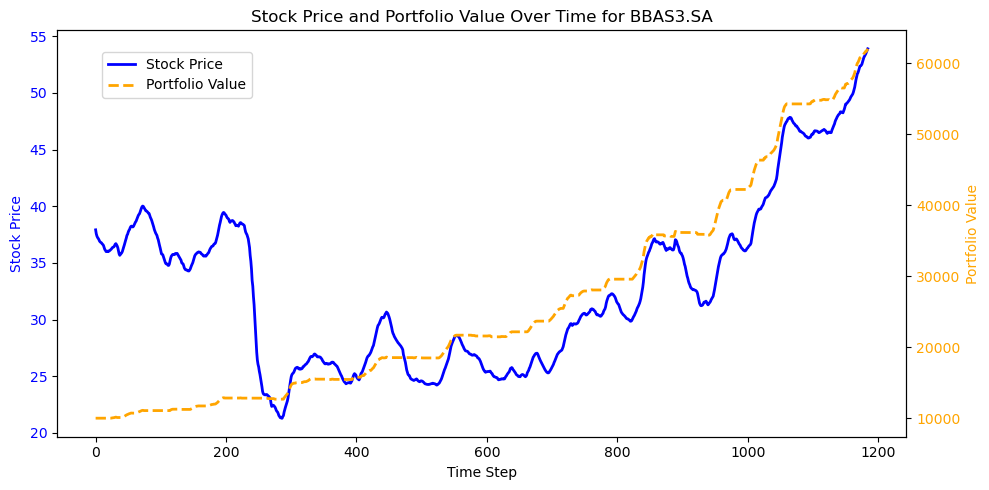


Test results for stock: CSNA3.SA
sequential_5
Accuracy: 0.89
Precision: 0.87
Recall: 0.86
F1 Score: 0.86
Confusion Matrix:


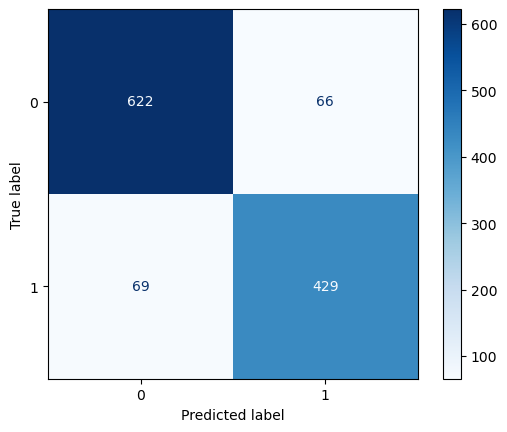


Final portfolio value for CSNA3.SA: R$249093.74


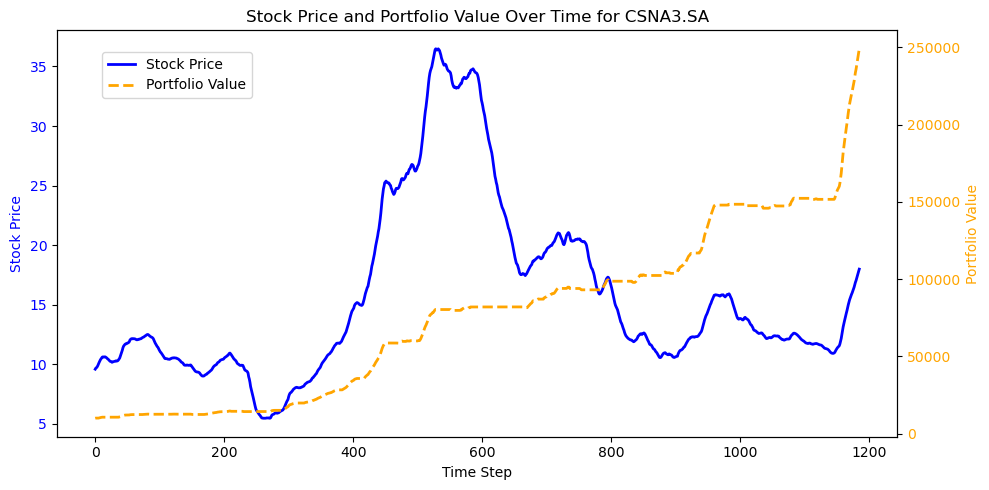


Test results for stock: PETR4.SA
sequential_6
Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1 Score: 0.87
Confusion Matrix:


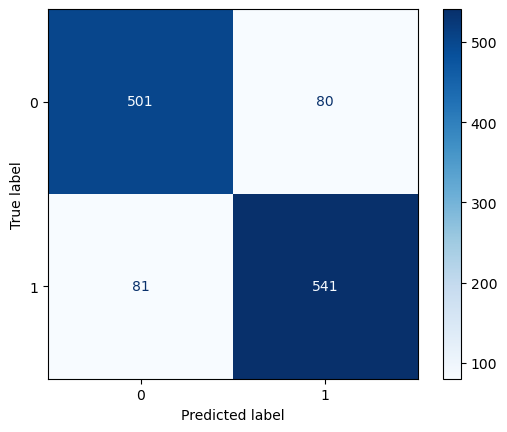


Final portfolio value for PETR4.SA: R$147650.60


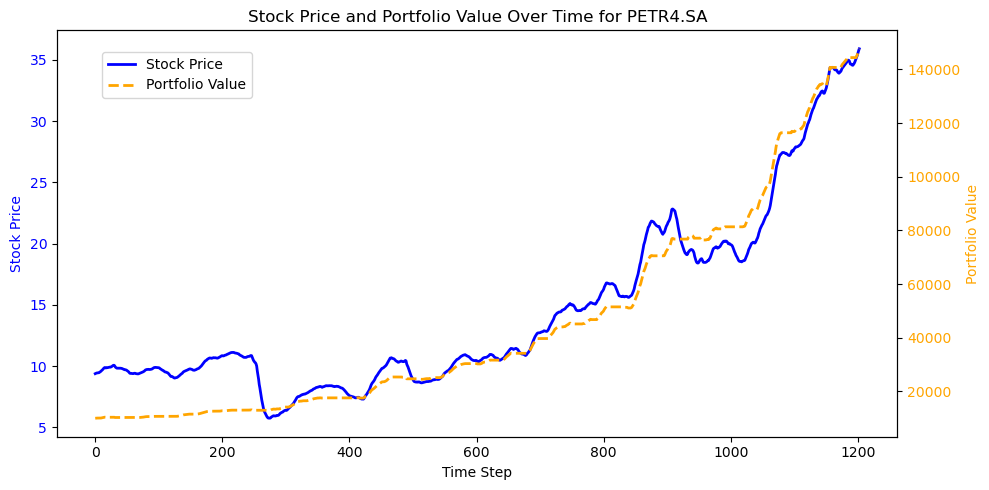


Test results for stock: VALE3.SA
sequential_7
Accuracy: 0.89
Precision: 0.90
Recall: 0.86
F1 Score: 0.88
Confusion Matrix:


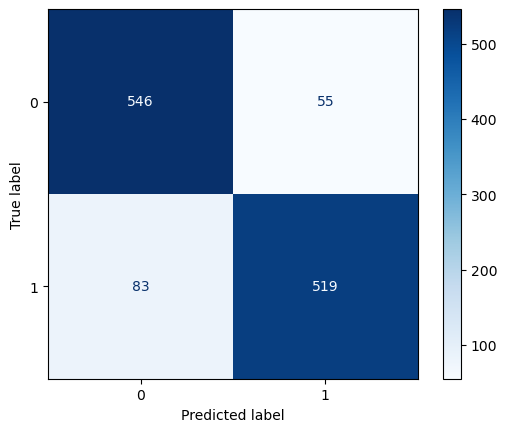


Final portfolio value for VALE3.SA: R$86474.91


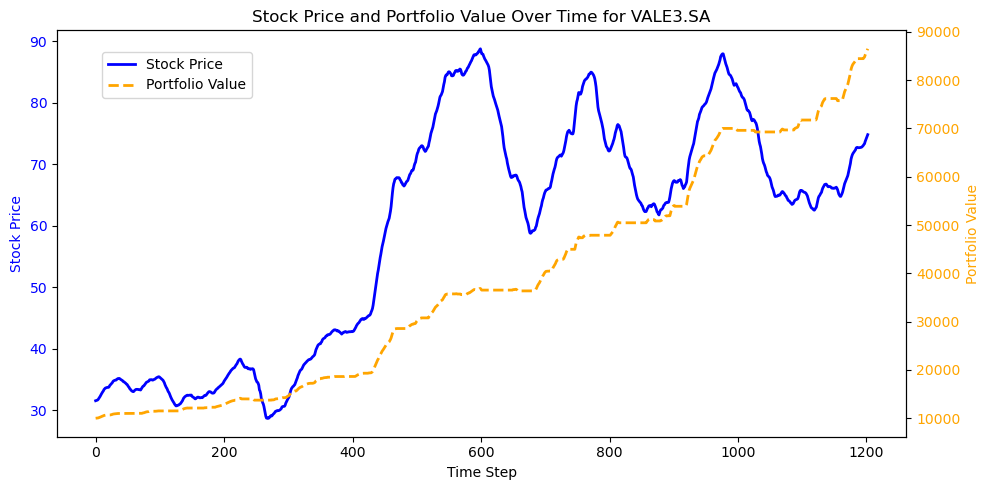

In [16]:
results(cnn_stock_models)